1. Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import math

2. Importing Data and Initial Analysis

In [2]:
data = pd.read_csv("winequality-red.csv")
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


3. Data Processing and Visualization

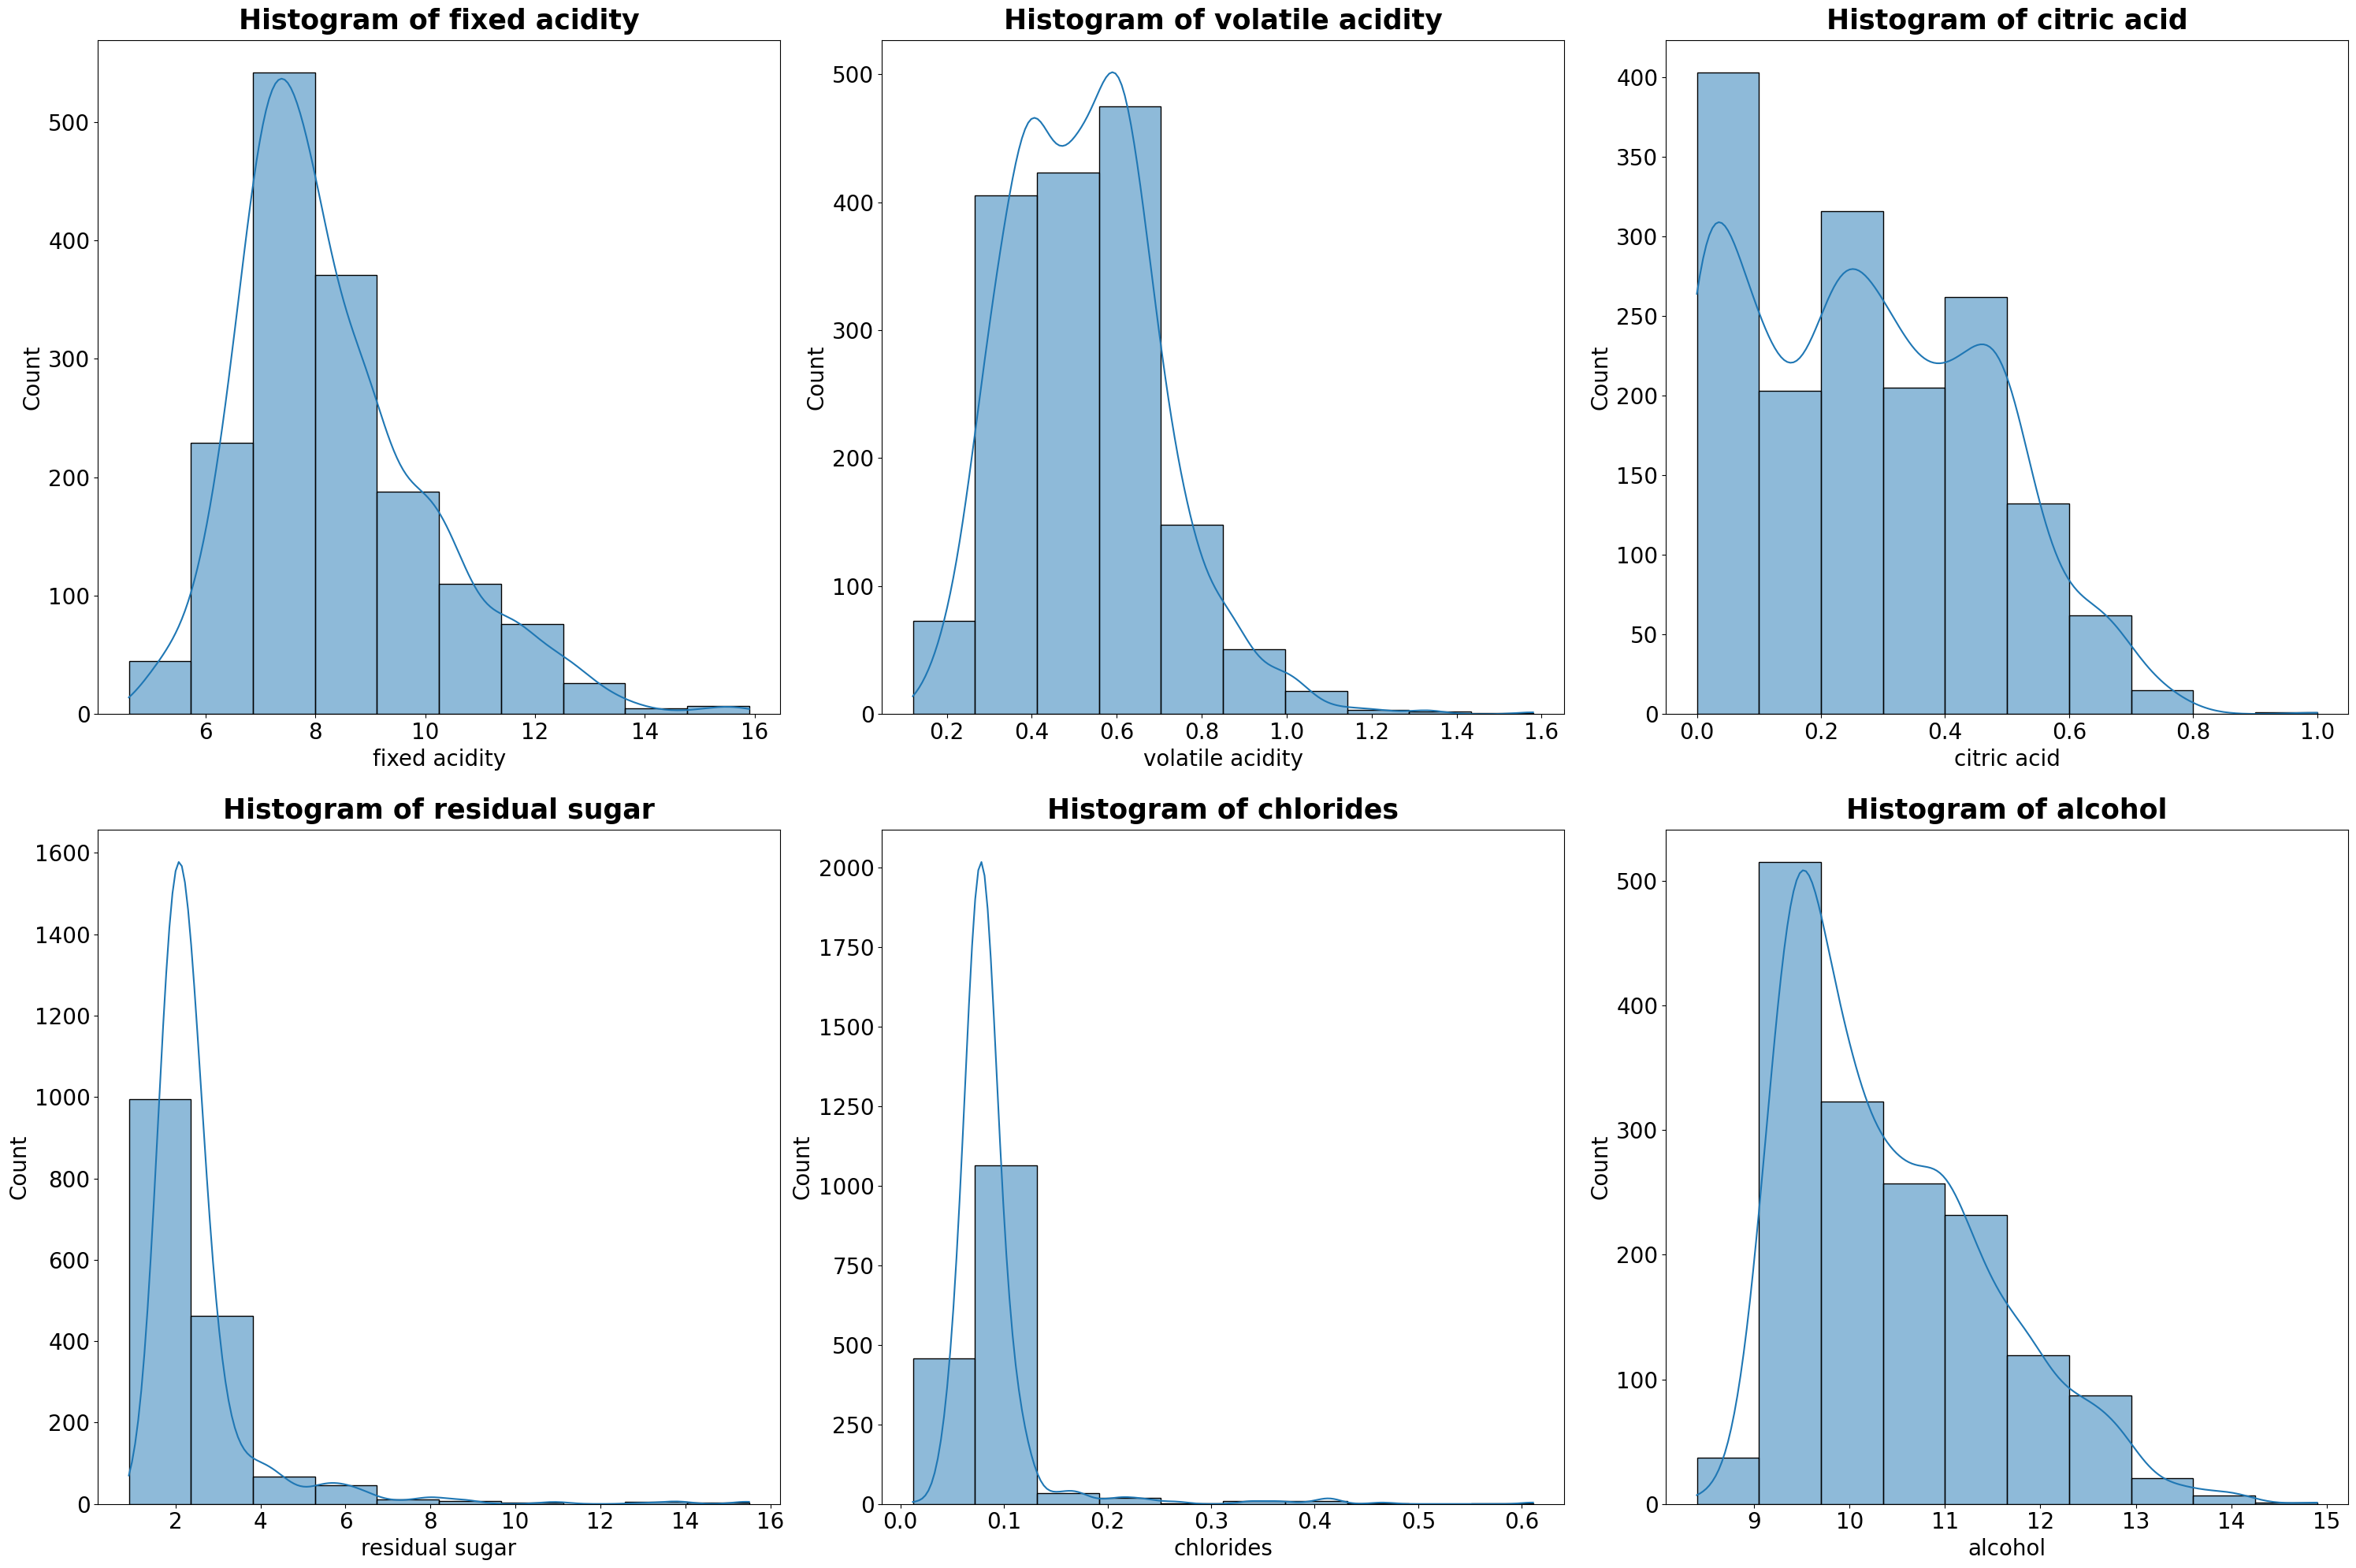

In [4]:
params1 = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'alcohol']

fig, axes = plt.subplots(2, 3, figsize=(30,20))
for i, param in enumerate(params1):
    row = i // 3
    col = i % 3
    sns.histplot(data=data[param], 
                 ax=axes[row, col],                 
                 bins=10,
                 cbar=True,
                 kde=True)
    # pad asegura espacio entre el titulo y el subplot
    axes[row, col].set_title(f"Histogram of {param}", fontsize='25', fontweight='bold', pad=10)
    axes[row, col].set_xlabel(f"{param}", fontsize='20')
    axes[row, col].set_ylabel("Count", fontsize='20')
    axes[row, col].tick_params(labelsize='20')

plt.tight_layout(h_pad=2.5)
plt.show()


The majority of the features do not follow a normal distribution. Therefore, we will need to apply a transformation such as StandardScaler before inputting them into the model.

In [5]:
data['quality'].unique()

array([5, 6, 7, 4, 8, 3], dtype=int64)

In [6]:
data.quality.value_counts()

quality
5    681
6    638
7    199
4     53
8     18
3     10
Name: count, dtype: int64

The dataset shows a prevalence of wines rated 5 and 6, with fewer instances of ratings 3, 4, and '8', indicating an imbalance. Proceeding without balancing techniques may lead to inflated accuracy as the model may simply predict the majority class. However, our aim is for the model to identify key patterns that define wine quality accurately.

Now since we have categories which are minorities we will oversample them in order to get a balanced dataset. One very famous method to use is SMOTE(Synthetic Minority Oversampling Technique).

In [7]:
# SMOTE from scratch
def euclidean_dist(x1, x2):
    '''x1 and x2 are parameters (array), return type float'''
    return np.sqrt(np.sum((x1 - x2) ** 2))

def nearest_neighbors(x, X, k):
    '''x(array), X(dataset), k(number of neighbors to find)'''
    dist = [euclidean_dist(x, x_) for x_ in X]
    return np.argsort(dist)[1:k+1]

def SMOTE(X, y, k, n_samples):
    '''SMOTE algorithm'''
    X_resampled = []
    y_resampled = []

    min_class = np.unique(y)[np.argmin(np.bincount(y))]
    maj_class = np.unique(y)[np.argmax(np.bincount(y))]

    min_indices = np.where(y == min_class)[0]

    for idx in min_indices:
        nn_indices = nearest_neighbors(X[idx], X, k)
        for _ in range(n_samples):
            nn_index = np.random.choice(nn_indices)
            diff = X[nn_index] - X[idx]
            synthetic_sample = X[idx] + np.random.random() * diff
            X_resampled.append(synthetic_sample)
            y_resampled.append(min_class)

    X_resampled = np.vstack((X, np.array(X_resampled)))
    y_resampled = np.hstack((y, np.array(y_resampled)))

    return X_resampled, y_resampled

In [8]:
# Shuffling the dataset
np.random.seed(42)
data_shuffled_ind = np.random.permutation(len(data))
data_shuffled = data.iloc[data_shuffled_ind]

In [9]:
# Applying the algorithm
X_resampled, y_resampled = SMOTE(data_shuffled.drop('quality', axis=1).values, data_shuffled.quality.values,
                                 k=5, n_samples=100)

In [10]:
# Concatenating the original and synthetic samples
syn_data = pd.DataFrame(X_resampled, columns=data_shuffled.drop('quality', axis=1).columns)
syn_data['quality'] = y_resampled

In [11]:
# Concatenate original and synthetic data
balanced_data = pd.concat([data_shuffled, syn_data])

In [12]:
# Print class counts to verify balance
print(balanced_data['quality'].value_counts())

quality
5    1362
6    1276
3    1020
7     398
4     106
8      36
Name: count, dtype: int64


In [13]:
data = balanced_data

<Axes: >

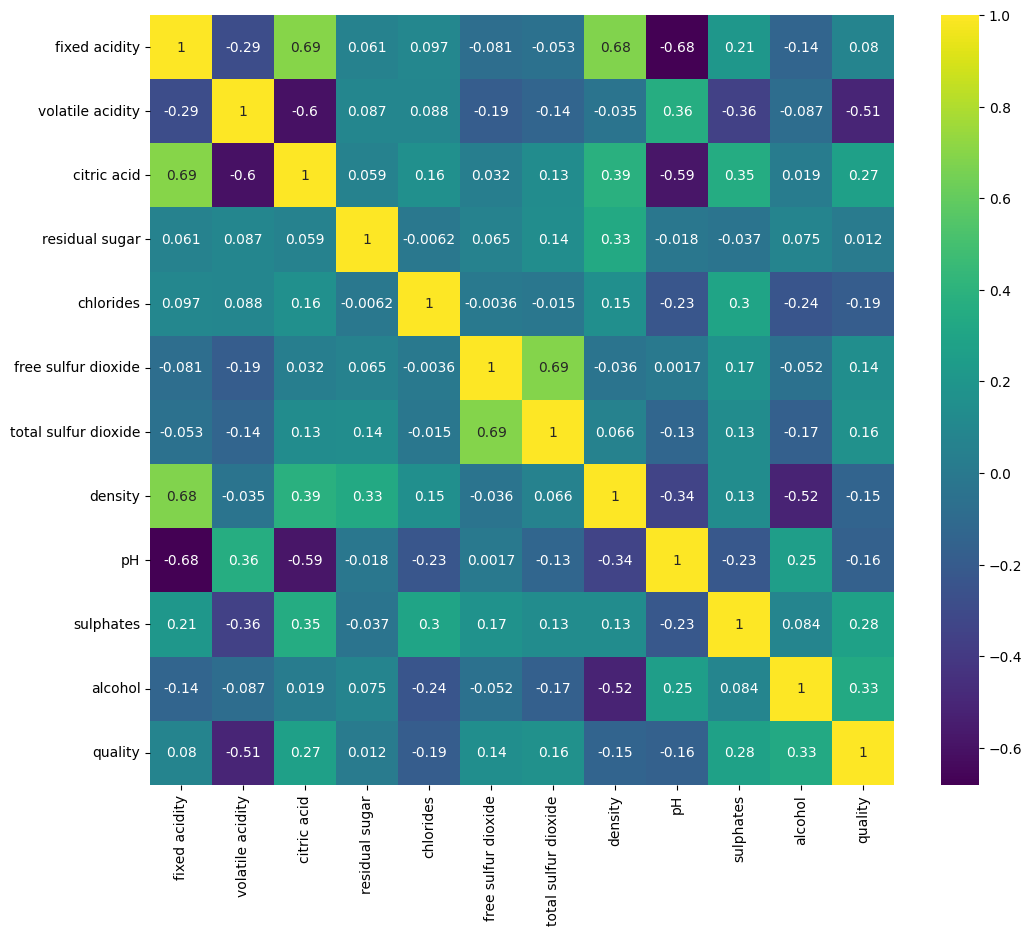

In [14]:
plt.figure(figsize=(12, 10))
sns.heatmap(data.corr(), annot=True, cmap='viridis')

It seems that there is low correlation between 'fixed acidity' and 'residual sugar' with 'quality'. Therefore, we will choose only the columns where the absolute correlation value exceeds 0.1.

In [15]:
selected_columns = data.corr()[abs(data.corr()['quality']) > 0.1].index.tolist()
data = data[selected_columns]
data.head()

,volatile acidity,citric acid,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
803,0.56,0.08,0.114,14.0,46.0,0.9971,3.24,0.66,9.6,6
124,0.50,0.17,0.082,21.0,102.0,0.9960,3.39,0.48,9.5,5
350,0.67,0.22,0.107,17.0,34.0,1.0004,3.28,0.98,9.9,6
682,0.46,0.31,0.078,32.0,58.0,0.9980,3.33,0.54,9.8,5
1326,0.46,0.24,0.077,18.0,34.0,0.9948,3.39,0.60,10.6,6


Now that we have identified the highly correlated columns, let's analyze their distribution using a box plot, which is a valuable tool for detecting outliers in the dataset

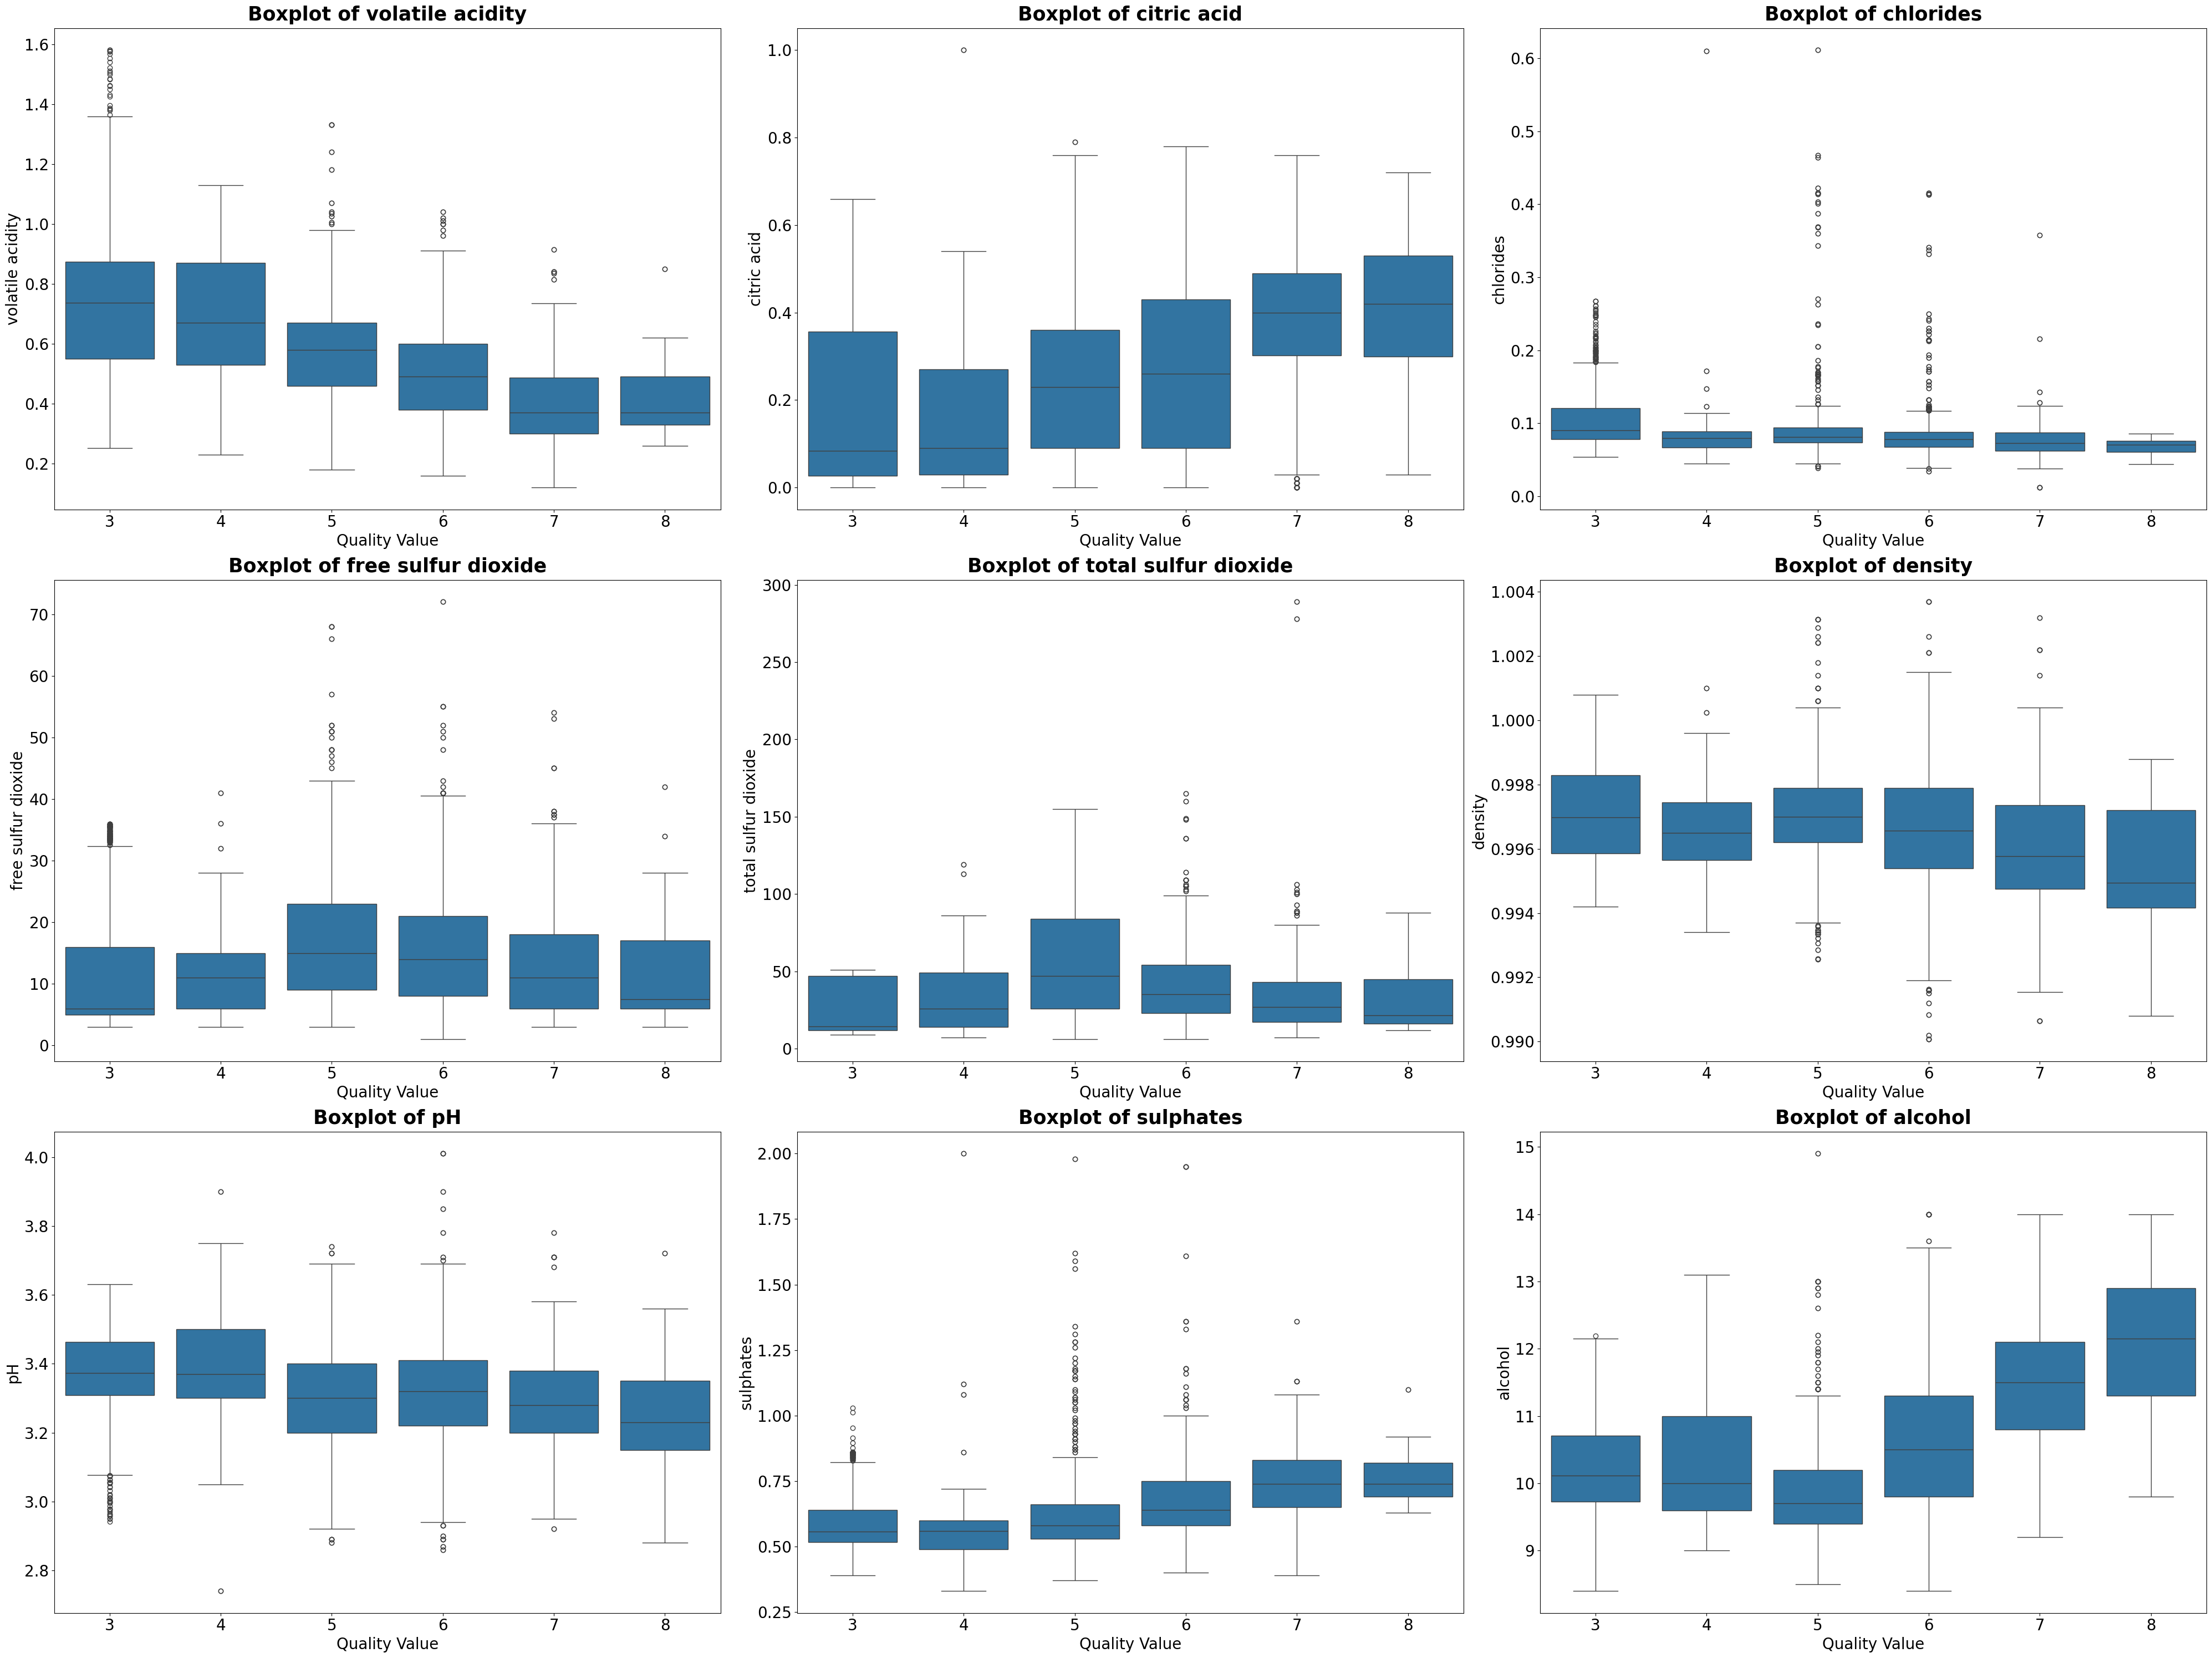

In [16]:
fig, axes = plt.subplots(3, 3, figsize=(40, 30))
c_list = data.columns.tolist()[:-1]

for i, param in enumerate(c_list):
    row = i // 3
    col = i % 3
    sns.boxplot(ax=axes[row, col],
        x='quality',
        y=param,
        data=data,
        )
    axes[row, col].set_title(f"Boxplot of {param}", fontsize='25', fontweight='bold', pad=10)
    axes[row, col].set_xlabel("Quality Value", fontsize='20')
    axes[row, col].set_ylabel(f"{param}", fontsize='20')
    axes[row, col].tick_params(labelsize='20')
   
plt.tight_layout()
plt.show()


There are numerous outliers in the dataset, which can impact the model training by introducing extreme values that may lead to incorrect pattern learning. To address this issue, we will utilize the IQR (Inter-Quartile Range) method for outlier removal. More information on IQR can be found here: IQR.

In [17]:
def rem_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    iqr = Q3 - Q1
    lower_bound = Q1 - 1.5 * iqr
    upper_bound = Q3 + 1.5 * iqr
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]


In [21]:
def rem_outliers_multiple_columns(df, columns):
    # df is the dataframe and columns is a list of columns from where the outliers will be removed
    df_clean = df.copy()
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[column] >= lower_bound) & (df_clean[column] <= upper_bound)]
    return df_clean

In [22]:
col_to_remove_outliers = ['volatile acidity', 'citric acid', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']

In [28]:
data_cleaned = rem_outliers_multiple_columns(data, col_to_remove_outliers)
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3347 entries, 803 to 2598
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   volatile acidity      3347 non-null   float64
 1   citric acid           3347 non-null   float64
 2   chlorides             3347 non-null   float64
 3   free sulfur dioxide   3347 non-null   float64
 4   total sulfur dioxide  3347 non-null   float64
 5   density               3347 non-null   float64
 6   pH                    3347 non-null   float64
 7   sulphates             3347 non-null   float64
 8   alcohol               3347 non-null   float64
 9   quality               3347 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 287.6 KB


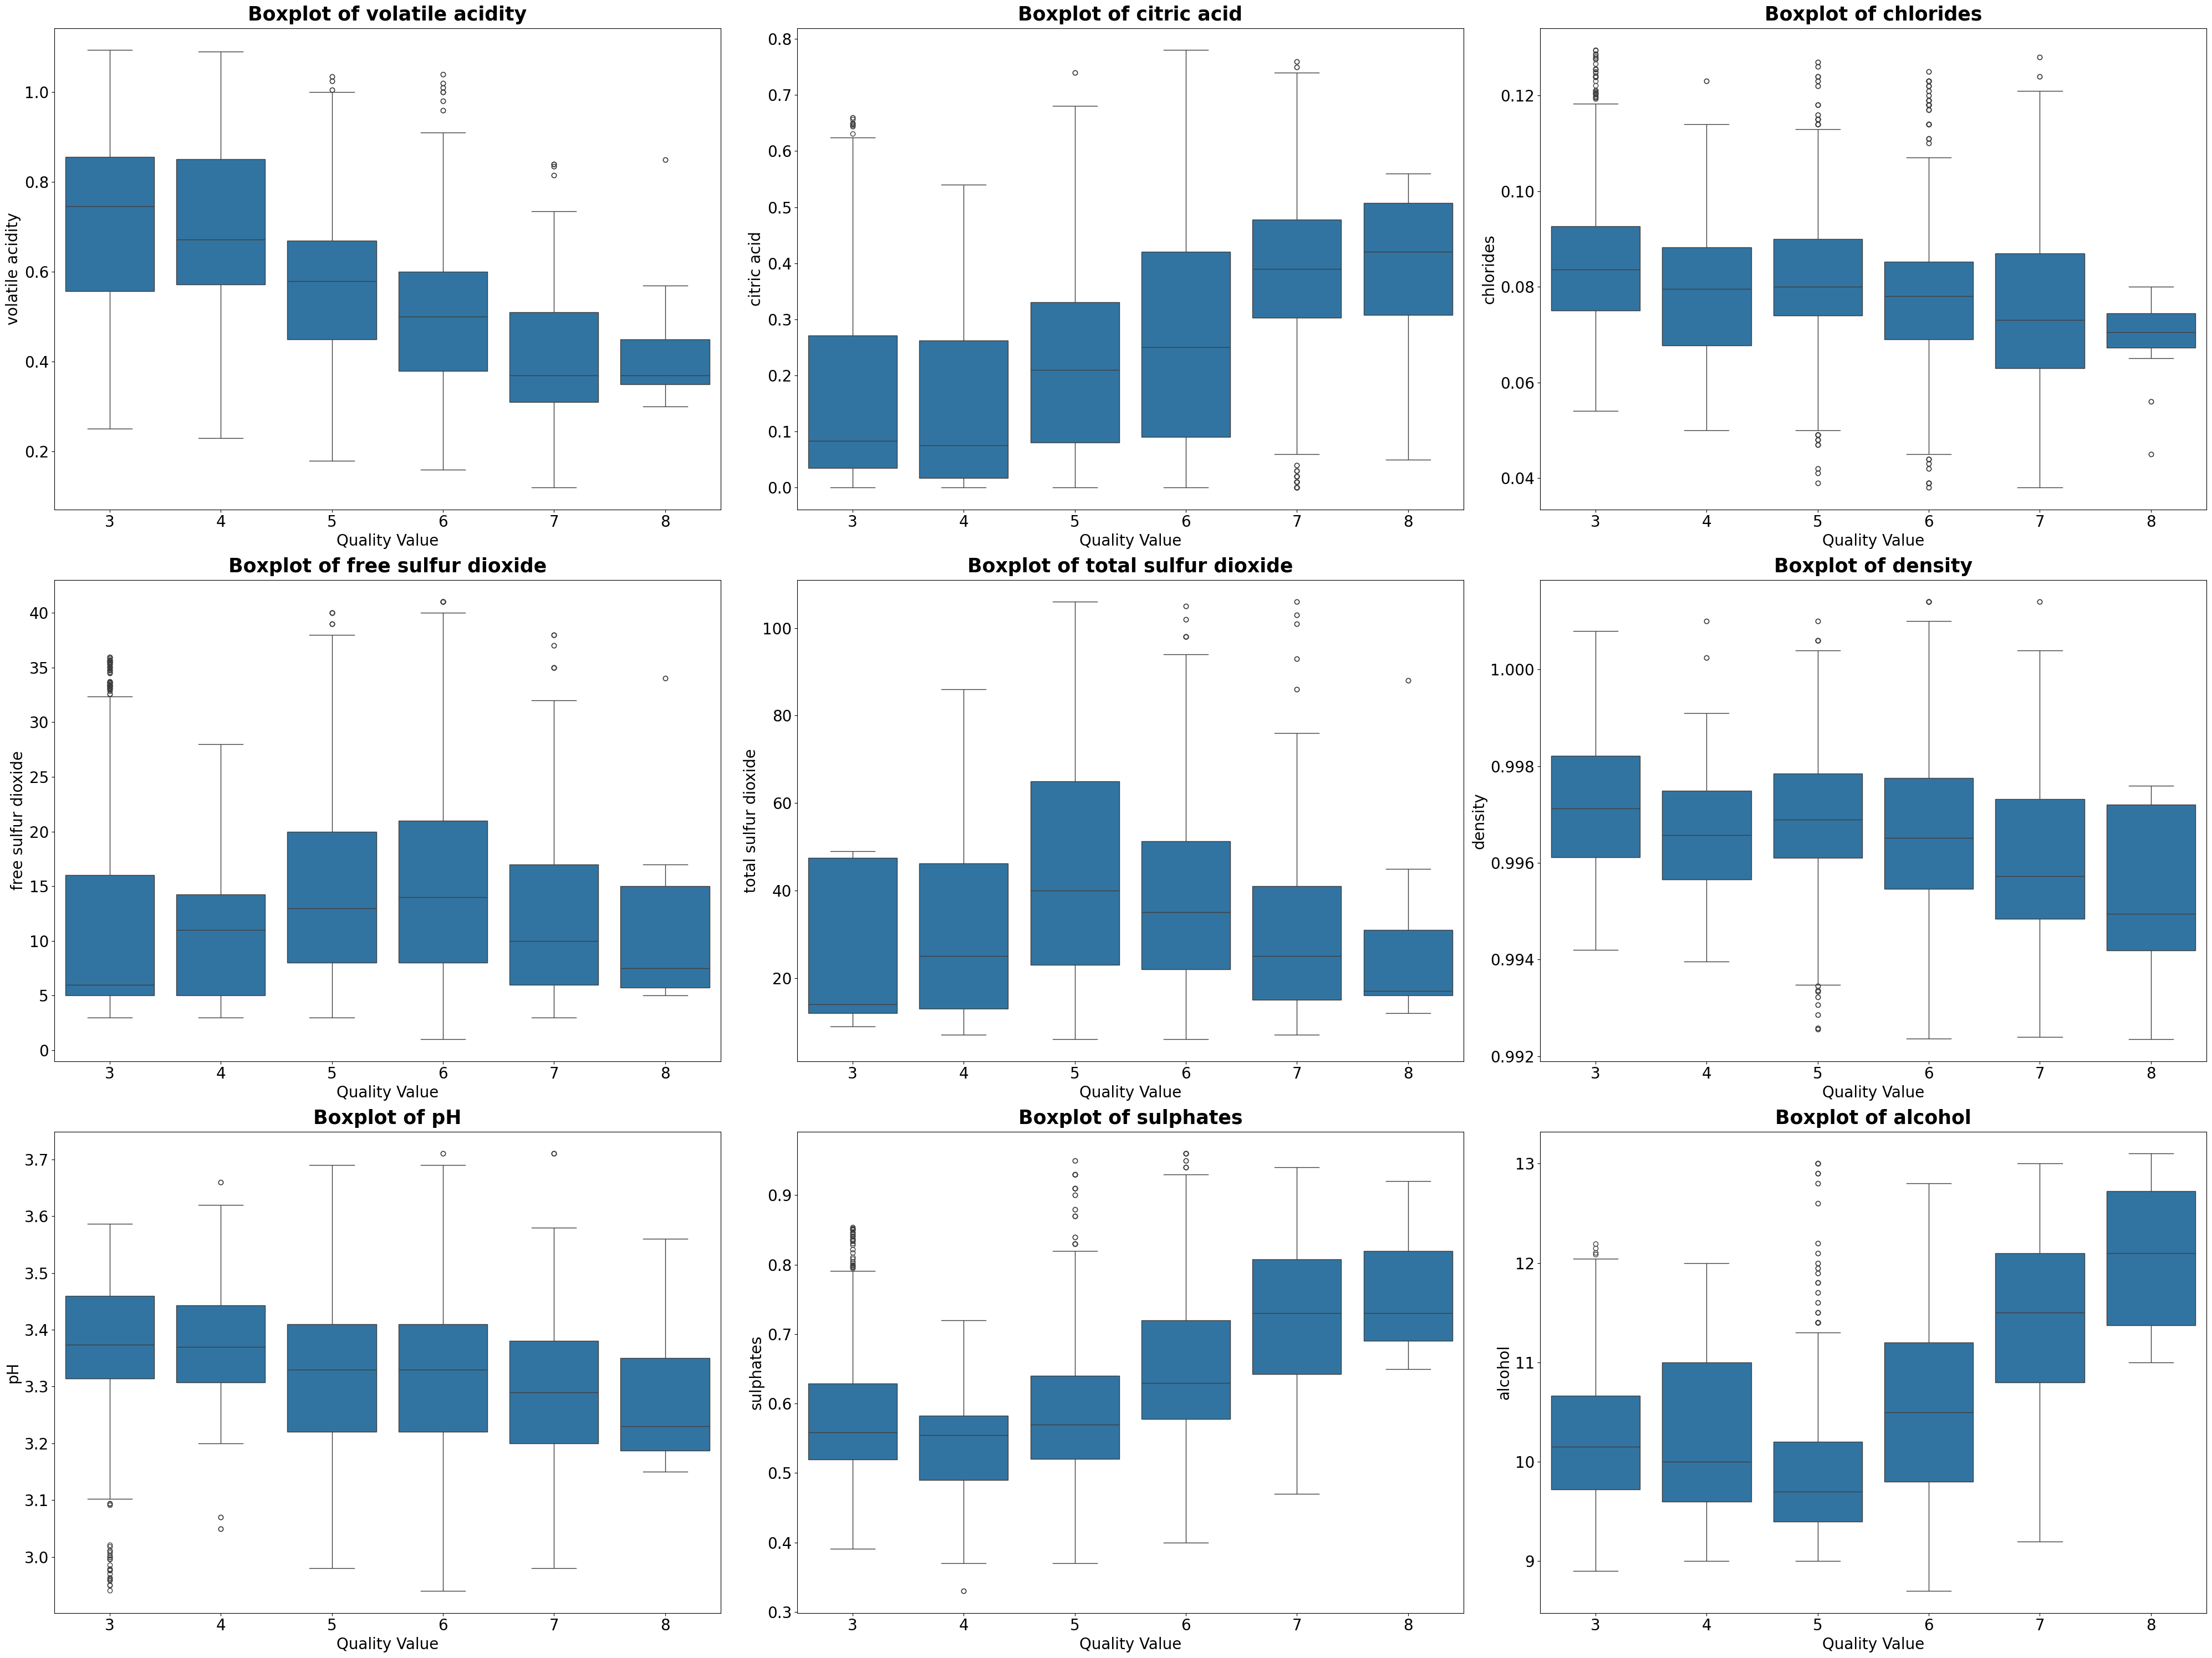

In [30]:
# Checking with a boxplot if the applied function works
fig, axes = plt.subplots(3, 3, figsize=(40, 30))
c_list = col_to_remove_outliers

for i, param in enumerate(c_list):
    row = i // 3
    col = i % 3
    sns.boxplot(ax=axes[row, col],
        x='quality',
        y=param,
        data=data_cleaned,
        )
    axes[row, col].set_title(f"Boxplot of {param}", fontsize='25', fontweight='bold', pad=10)
    axes[row, col].set_xlabel("Quality Value", fontsize='20')
    axes[row, col].set_ylabel(f"{param}", fontsize='20')
    axes[row, col].tick_params(labelsize='20')
   
plt.tight_layout()
plt.show()

We will create a classification model by splitting the 'quality' column into two parts: 'Good' for quality 6 and above, and 'Bad' for quality 5 and below. A new column 'good_quality' will be added with binary values: '0' for 'Bad' and '1' for 'Good' quality.

In [33]:
data_cleaned['good_quality'] = data_cleaned.quality.apply(lambda x: 0 if x <= 5 else 1)
data_cleaned = data_cleaned.drop('quality', axis=1)
data_cleaned.head()

,volatile acidity,citric acid,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,good_quality
803,0.56,0.08,0.114,14.0,46.0,0.9971,3.24,0.66,9.6,1
124,0.50,0.17,0.082,21.0,102.0,0.9960,3.39,0.48,9.5,0
682,0.46,0.31,0.078,32.0,58.0,0.9980,3.33,0.54,9.8,0
1326,0.46,0.24,0.077,18.0,34.0,0.9948,3.39,0.60,10.6,1
976,0.41,0.30,0.083,35.0,72.0,0.9970,3.44,0.52,9.4,0


C:\Users\robme\AppData\Local\Temp\ipykernel_17428\3516297113.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(data_cleaned['good_quality'], sort=True).sort_index()


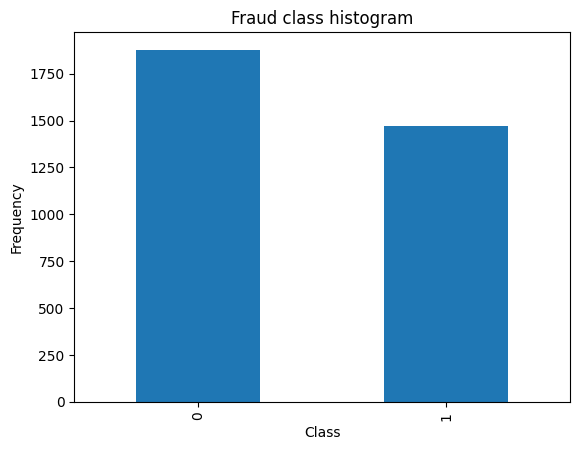

In [34]:
count_classes = pd.value_counts(data_cleaned['good_quality'], sort=True).sort_index()
count_classes.plot(kind='bar')
plt.title('Fraud class histogram')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

In [36]:
print('Bad quality', data_cleaned['good_quality'].value_counts()[0])
print('Good quality', data_cleaned['good_quality'].value_counts()[1])

Bad quality 1877
Good quality 1470


As you can see now, the counts of each category are nearly the same. I.e. We have removed the imbalance from the dataset. Hence, now our data is ready for the model training.

In [37]:
y = data_cleaned['good_quality']
X = data_cleaned.drop('good_quality', axis=1)
X.head(10)

,volatile acidity,citric acid,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
803,0.56,0.08,0.114,14.0,46.0,0.99710,3.24,0.66,9.60
124,0.50,0.17,0.082,21.0,102.0,0.99600,3.39,0.48,9.50
682,0.46,0.31,0.078,32.0,58.0,0.99800,3.33,0.54,9.80
1326,0.46,0.24,0.077,18.0,34.0,0.99480,3.39,0.60,10.60
976,0.41,0.30,0.083,35.0,72.0,0.99700,3.44,0.52,9.40
706,0.78,0.08,0.093,10.0,19.0,0.99560,3.40,0.47,10.00
613,0.39,0.38,0.058,10.0,29.0,0.99620,3.26,0.74,9.80
1587,0.61,0.11,0.066,18.0,28.0,0.99483,3.55,0.66,10.90
513,0.51,0.64,0.107,6.0,15.0,0.99730,3.09,0.66,11.80
1505,0.76,0.02,0.078,6.0,12.0,0.99600,3.55,0.63,9.95


In [41]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X = sc.fit_transform(X)
X = pd.DataFrame(X, columns=col_to_remove_outliers)
X

,volatile acidity,citric acid,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,-0.031028,-0.832506,2.154972,0.012025,0.372975,0.171291,-0.678245,0.321912,-0.827287
1,-0.342843,-0.362615,0.097300,0.792380,2.755702,-0.500564,0.420563,-1.264483,-0.934206
2,-0.550719,0.368327,-0.159909,2.018654,0.883559,0.720990,-0.018960,-0.735684,-0.613450
3,-0.550719,0.002856,-0.224211,0.457942,-0.137609,-1.233496,0.420563,-0.206886,0.241900
4,-0.810565,0.316117,0.161602,2.353092,1.479241,0.110213,0.786832,-0.911950,-1.041125
...,...,...,...,...,...,...,...,...,...
3342,0.811658,0.521033,-0.182742,-0.271360,0.446541,1.006382,-0.978795,-0.856769,-1.001149
3343,-0.041036,1.737785,-0.064650,-0.433893,0.392201,2.069588,-0.625068,-0.398821,-1.263676
3344,0.097183,2.043953,-0.360389,-0.422323,0.417732,2.370307,-0.582182,-0.485006,-1.441057
3345,-0.070667,1.618711,0.027007,-0.433893,0.386136,1.975563,-0.630288,-0.379977,-1.210335


In [43]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [44]:
X_train.shape

(2677, 9)

In [45]:
y_train.shape

(2677,)

4. Model Implementation

In [50]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
dt_predict = dt.predict(X_test)

In [51]:
dt_conf_matrix = confusion_matrix(y_test, dt_predict)
dt_acc_score = accuracy_score(y_test, dt_predict)

print("Decision Tree's accuracy score is: ", dt_acc_score * 100)
print(dt_conf_matrix)
print(classification_report(y_test, dt_predict))

Decision Tree's accuracy score is:  95.07462686567165
[[343  19]
 [ 14 294]]
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       362
           1       0.94      0.95      0.95       308

    accuracy                           0.95       670
   macro avg       0.95      0.95      0.95       670
weighted avg       0.95      0.95      0.95       670

